In [1]:
"""環境"""
# .lab

"""更新履歴"""
# 最終更新日：2025/05/21
# 2025/05/21 shutilを使って、cachedirを洗浄することにしました
# 2025/05/15 simple_progress_barおよびdata(dict)を使い始めました。
# 2025/02/25 os.getcwd()を採用し、__file__を定義する必要をなくしました。

"""モジュール読み込み"""
# ファイル操作等
import sys
import os
from datetime import datetime
from pprint import pprint
import logging
import pickle
# import struct
from tqdm import tqdm
import h5py
# import threading
import json

# tkinter
from tkinter import filedialog, messagebox, Tk

# データ分析ツール
import pandas as pd
import numpy as np
import scipy as sp
# import math
# from sklearn.linear_model import LinearRegression

# グラフ等作成用
import matplotlib
import matplotlib.pyplot as plt         # 図の作成用
from PIL import Image as im
# import cv2
from IPython.display import display, HTML, clear_output, update_display, Image

# 自作モジュール
sys.path.append(r"C:\Users\okaza\pythonenv")
from modules.Mytools.Tools import print_fileinfo, h5_tree, dict_tree, simple_progress_bar, clean_cache_except_logfiles, get_total_size
import modules.Mytools.Settings
import modules.fitXRD as fx
from modules.peakfit import peakfit, pseudoVoigt

"""ログ管理ツール作成"""
# chche directoryの設定
cachedir = os.path.abspath(os.getcwd() + "/.cache")
clean_cache_except_logfiles(cachedir)
os.makedirs(cachedir, exist_ok=True)

# loggerの作成
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
format = "%(levelname)-9s  %(asctime)s [%(filename)s:%(lineno)d] %(message)s"

# Streamハンドラクラスを作成
sh = logging.StreamHandler()
sh.setLevel(logging.DEBUG)
sh.setFormatter(logging.Formatter(format))
logger.addHandler(sh)

# Fileハンドラクラスをインスタンス化
logfile = cachedir + ""
fh = logging.FileHandler(filename=cachedir + "/notebook.log", encoding="utf-8")
fh.setLevel(logging.DEBUG)
fh.setFormatter(logging.Formatter(format))
logger.addHandler(fh)
logger.debug("[Activate workspace]: " + os.getcwd())
logger.debug("[Set cache]: "+ os.path.abspath(cachedir))
logger.debug("[Activate log]: " + os.path.abspath(cachedir + "/notebook.log"))

# globalなデータを作成
data = dict()
logger.debug("[Create global variable]: data")

DEBUG      2025-07-22 12:47:32,559 [2108053463.py:71] [Activate workspace]: c:\Users\okaza\pythonenv\lf\get_average
DEBUG      2025-07-22 12:47:32,560 [2108053463.py:72] [Set cache]: c:\Users\okaza\pythonenv\lf\get_average\.cache
DEBUG      2025-07-22 12:47:32,560 [2108053463.py:73] [Activate log]: c:\Users\okaza\pythonenv\lf\get_average\.cache\notebook.log
DEBUG      2025-07-22 12:47:32,561 [2108053463.py:77] [Create global variable]: data


In [12]:
def save_pickle():

    # 現在時刻の取得
    dt = datetime.now()
    initfilename = dt.strftime('%Y%m%d%H%M%S%f') + ".pkl"

    # tkinterでファイルダイアログを開く
    window = Tk()
    window.wm_attributes("-topmost", 1)
    window.withdraw()
    filename = filedialog.asksaveasfilename(
        parent = window,
        filetypes = [
            ("pkl", "*.pkl"),
        ],
        initialfile=initfilename
    )

    if not (filename == ""):
        with open(filename, mode = "wb") as f:
            pickle.dump(
                obj = data,
                file = f
            )
    logger.info("[Save data]: " + os.path.abspath(filename))

    return
save_pickle()
del save_pickle

INFO       2025-07-22 12:59:16,812 [2685589408.py:25] [Save data]: C:\Users\okaza\Box\DataStrorage\SPring8-2025-07\mDIH20_0016\Analyze\get_average\20250722125907741399_accumulated.pkl


In [ ]:
def load_pickle():

    # tkinterでファイルダイアログを開く
    window = Tk()
    window.wm_attributes("-topmost", 1)
    window.withdraw()
    filename = filedialog.askopenfilename(
        parent = window,
        filetypes = [
            ("pkl", "*.pkl"),
        ],
    )
    if not (filename == ""):
        with open(filename, mode = "rb") as f:
            data = pickle.load(
                file = f
            )

    logger.info("[Load]: " + os.path.abspath(filename))
    dict_tree(data)
    print(data)



    return
load_pickle()
del load_pickle

## 目的

温度データを1次元csvに変換します

## 1. 温度計算結果の可視化

In [2]:
import matplotlib.animation as anim

hdffileを読み込み、平均値を計算します。

In [11]:
def calc_ave():

    # 計算する温度範囲
    temp_range = (1000, 3000)

    # hdfファイルを別ディレクトリから読み込む場合はこちら (optional)
    hdffile = r"C:\Users\okaza\Box\DataStrorage\SPring8-2025-07\mDIH20_0016\Analyze\twocolor\output\calc_temp.hdf"
    hdffile = r"C:\Users\okaza\Box\DataStrorage\SPring8-2025-07\mDIH20_0016\Analyze\twocolor_acm\.cache\calc_temp.hdf"

    if True: # [ Main ]

        # 読み込むhdffile
        if not "hdffile" in locals():
            hdffile = "../twocolor/.cache/calc_temp.hdf"

        # ファイルが存在する場合続ける
        if os.path.exists(hdffile):
            logger.info("[Load hdf]: " + os.path.abspath(hdffile))
        else:
            raise KeyError("calc_temp.hdf does not exist.")

        # hdfファイルの読み込み開始
        with h5py.File(hdffile, mode = "r") as f:
            
            # 読み込み始める前の下準備
            d = dict()
            n_total = 0
            for stream in f.keys():
                n_total += len(f[stream].keys()) # type: ignore
            i = 0
            
            # それぞれの温度データを読み込む
            for stream in f.keys(): # type: ignore

                # ピクセルの順番を整理
                pixes = list(f[stream].keys()) # type: ignore
                pixes.sort(key = (lambda x: int(x.replace("pix = ", ""))))

                # データ格納の準備
                d[stream] = dict()
                d[stream]["data"] = []
                d[stream]["err"] = []
                d[stream]["pixes"] = pixes

                # それぞれのフレームごとに操作
                for pix in pixes: # type: ignore

                    # 各pixelのフレームを整理
                    temp = []
                    err = []
                    frames = list(f[stream][pix].keys()) # type: ignore
                    frames.sort(key = (lambda x: int(x.replace("frame = ", ""))))

                    # 各フレームで計算
                    for frame in frames:

                        # 温度データが存在する場合
                        if "data" in f[stream][pix][frame].keys(): # type: ignore

                            # 温度読み込み
                            t = np.array(f[stream][pix][frame]["data"][()]) # type: ignore
                            mask = np.ones(t.shape).astype(np.bool_)
                            mask[t < temp_range[0]] = False
                            mask[t > temp_range[1]] = False

                            # 平均値計算
                            temp.append(np.average(t[mask]))
                            err.append(np.std(t[mask], ddof = 1))

                        # 温度データが存在しない場合
                        else:
                            temp.append(300)
                            err.append(1)

                    # データ整理
                    d[stream]["data"].append(np.array(temp))
                    d[stream]["err"].append(np.array(err))
                    i += 1
                    simple_progress_bar(current = i, total = n_total)
                
                # データをnp.ndarrayに変換
                d[stream]["data"] = np.vstack(d[stream]["data"])
                d[stream]["err"] = np.vstack(d[stream]["err"])
        

        # # データ格納
        key = sys._getframe().f_code.co_name
        data[key] = dict()
        data[key]["average"] = d
        data[key]["temp_range"] = temp_range
        data[key]["n_total"] = n_total
        data[key]["hdf"] = hdffile
        logger.info("[Add variables]: {} (data = {:.2f} MB)".format(key, float(get_total_size(data))/1024/1024))

        # 出力
        dict_tree(data)

    return
calc_ave()
del calc_ave

INFO       2025-07-22 12:56:07,354 [1874302269.py:18] [Load hdf]: C:\Users\okaza\Box\DataStrorage\SPring8-2025-07\mDIH20_0016\Analyze\twocolor_acm\.cache\calc_temp.hdf


Progress: [■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■-]  98% (49/50) 

INFO       2025-07-22 12:58:23,848 [1874302269.py:93] [Add variables]: calc_ave (data = 0.36 MB)


Progress: [■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■] 100% (50/50) 

└── calc_ave
    ├── average
    │   ├── down
    │   │   ├── data <class 'numpy.ndarray'> [shape = (25, 467)]
    │   │   ├── err <class 'numpy.ndarray'> [shape = (25, 467)]
    │   │   └── pixes <class 'list'>
    │   └── up
    │       ├── data <class 'numpy.ndarray'> [shape = (25, 467)]
    │       ├── err <class 'numpy.ndarray'> [shape = (25, 467)]
    │       └── pixes <class 'list'>
    ├── temp_range <class 'tuple'>
    ├── n_total <class 'int'>
    └── hdf <class 'str'>

ヒストグラムを計算します

In [ ]:
def calc_hist():

    # ヒストグラムのステップ数
    step = 100

    if True: # [ Main ]

        # bins
        tlim = data["calc_ave"]["temp_range"]
        bins = np.linspace(*tlim, step) # type: ignore
        center = (bins[:-1] + bins[1:])/2

        # データ格納用
        histdata = dict()

        # プログレス用
        n_total = np.prod(data["calc_ave"]["average"]["up"]["data"].shape)
        n_total += np.prod(data["calc_ave"]["average"]["down"]["data"].shape)
        i = 0

        # グラフ作成
        with h5py.File(data["calc_ave"]["hdf"], mode = "r") as f:
            for stream in f.keys():
                histdata[stream] = []
                for pix in data["calc_ave"]["average"][stream]["pixes"]: # type: ignore

                    # データフォルダを用意する
                    _histdata = []

                    # フレームを整理
                    frames = list(f[stream][pix].keys()) # type: ignore
                    frames.sort(key = (lambda x: int(x.replace("frame = ", ""))))

                    # 各フレームごとに読み込み
                    for frame in frames:
                        # 例外処理
                        try:
                            temp = np.array(f[stream][pix][frame]["data"][()]) # type: ignore
                        except:
                            temp = []
                        
                        # ヒストグラム
                        hist, _ = np.histogram(temp, bins = bins)
                        _histdata.append(hist)

                        # 出力
                        i += 1
                        simple_progress_bar(current = i, total = n_total)

                    
                    # データを格納
                    histdata[stream].append(np.vstack(_histdata))
                histdata[stream] = np.stack(histdata[stream], axis = -1)
                

        # データ格納
        key = sys._getframe().f_code.co_name
        data[key] = dict()
        data[key]["data"] = histdata
        data[key]["total"] = n_total
        data[key]["bins"] = bins
        data[key]["center"] = center
        logger.info("[Add variablse]: {} (data = {:.2f} MB)".format(key, float(get_total_size(data))/1024/1024))
        dict_tree(data)

    return
calc_hist()
del calc_hist

動画を作成します。

In [ ]:
def make_anim():

    # フレーム数
    n_frame = data["calc_ave"]["average"]["up"]["data"].shape[1]

    # ピクセル
    index = dict()
    bins = dict()
    for st in ["up", "down"]:
        index[st] = [int(p.replace("pix = ", "")) for p in data["calc_ave"]["average"][st]["pixes"]]
        bins = data["calc_hist"]["bins"]

    # fig作成
    fig, axs = plt.subplots(1,2)
    fig.set_size_inches((8,6))
    fig.set_dpi(300)

    # axsの設定
    axs[0].set_title("up stream", fontsize = 12, loc = "left")
    axs[1].set_title("down stream", fontsize = 12, loc = "left")
    axs[0].set_ylim(data["calc_ave"]["temp_range"])
    axs[1].set_ylim(data["calc_ave"]["temp_range"])

    # 0番目のフレーム
    j = 26
    ims = []
    for i, st in enumerate(["up", "down"]):
        ims.append(axs[i].imshow(
            data["calc_hist"]["data"][st][j],
            aspect = "auto",
            extent = (
                min(index[st]) - 0.5,
                max(index[st]) + 0.5,
                min(bins),
                max(bins)
            ),
            origin = "lower",
            vmax = data["calc_hist"]["data"][st].max(),
            vmin = data["calc_hist"]["data"][st].min(),
        ))
    ims.append(axs[0].text(
        x = 0,
        y = 1.07,
        s = "frame = {:>4}".format(j),
        fontsize = 12,
        transform = axs[0].transAxes
    ))
    for i, st in enumerate(["up", "down"]):
        ims.append(axs[i].errorbar(
            x = index[st],
            y = data["calc_ave"]["average"][st]["data"].T[j],
            yerr = data["calc_ave"]["average"][st]["err"].T[j],
            lw = 0,
            fmt = "o",
            ms = 3,
            elinewidth = 1,
            c = "tab:orange"
        ))

    # フレームを変更する関数
    def update(frame):
        for i, st in enumerate(["up", "down"]):
            ims[i].set_data(data["calc_hist"]["data"][st][frame]) # type: ignore
            if len(ims) > 3+i:
                ims[3+i].remove()
            ims[3+i] = (
                axs[i].errorbar(
                    x = index[st],
                    y = data["calc_ave"]["average"][st]["data"].T[frame],
                    yerr = data["calc_ave"]["average"][st]["err"].T[frame],
                    lw = 0,
                    fmt = "o",
                    ms = 3,
                    elinewidth = 1,
                    c = "tab:orange"
                )
            )
        ims[2].set_text("frame = {:>4}".format(frame)) # type: ignore
        return ims

    # アニメ作成
    ani = anim.FuncAnimation(fig, update, frames=n_frame) # type: ignore
    plt.close()

    #. Save
    logger.debug("[Save]: Animation")
    key = sys._getframe().f_code.co_name
    filename = os.path.join(cachedir, key + ".mp4")
    ani.save(filename, writer = "ffmpeg", fps = 30, dpi = 300)
    logger.info("[Save]: " + os.path.abspath(filename))


    return
make_anim()
del make_anim

## 1次元データ保存

平均をとって1次元化します

DEBUG      2025-07-22 13:10:59,172 [3684429328.py:85] [calc_average]: c:\Users\okaza\pythonenv\lf\get_average\.cache\calc_average.csv
DEBUG      2025-07-22 13:10:59,256 [3684429328.py:130] [Save fig]: c:\Users\okaza\pythonenv\lf\get_average\.cache\calc_average.png


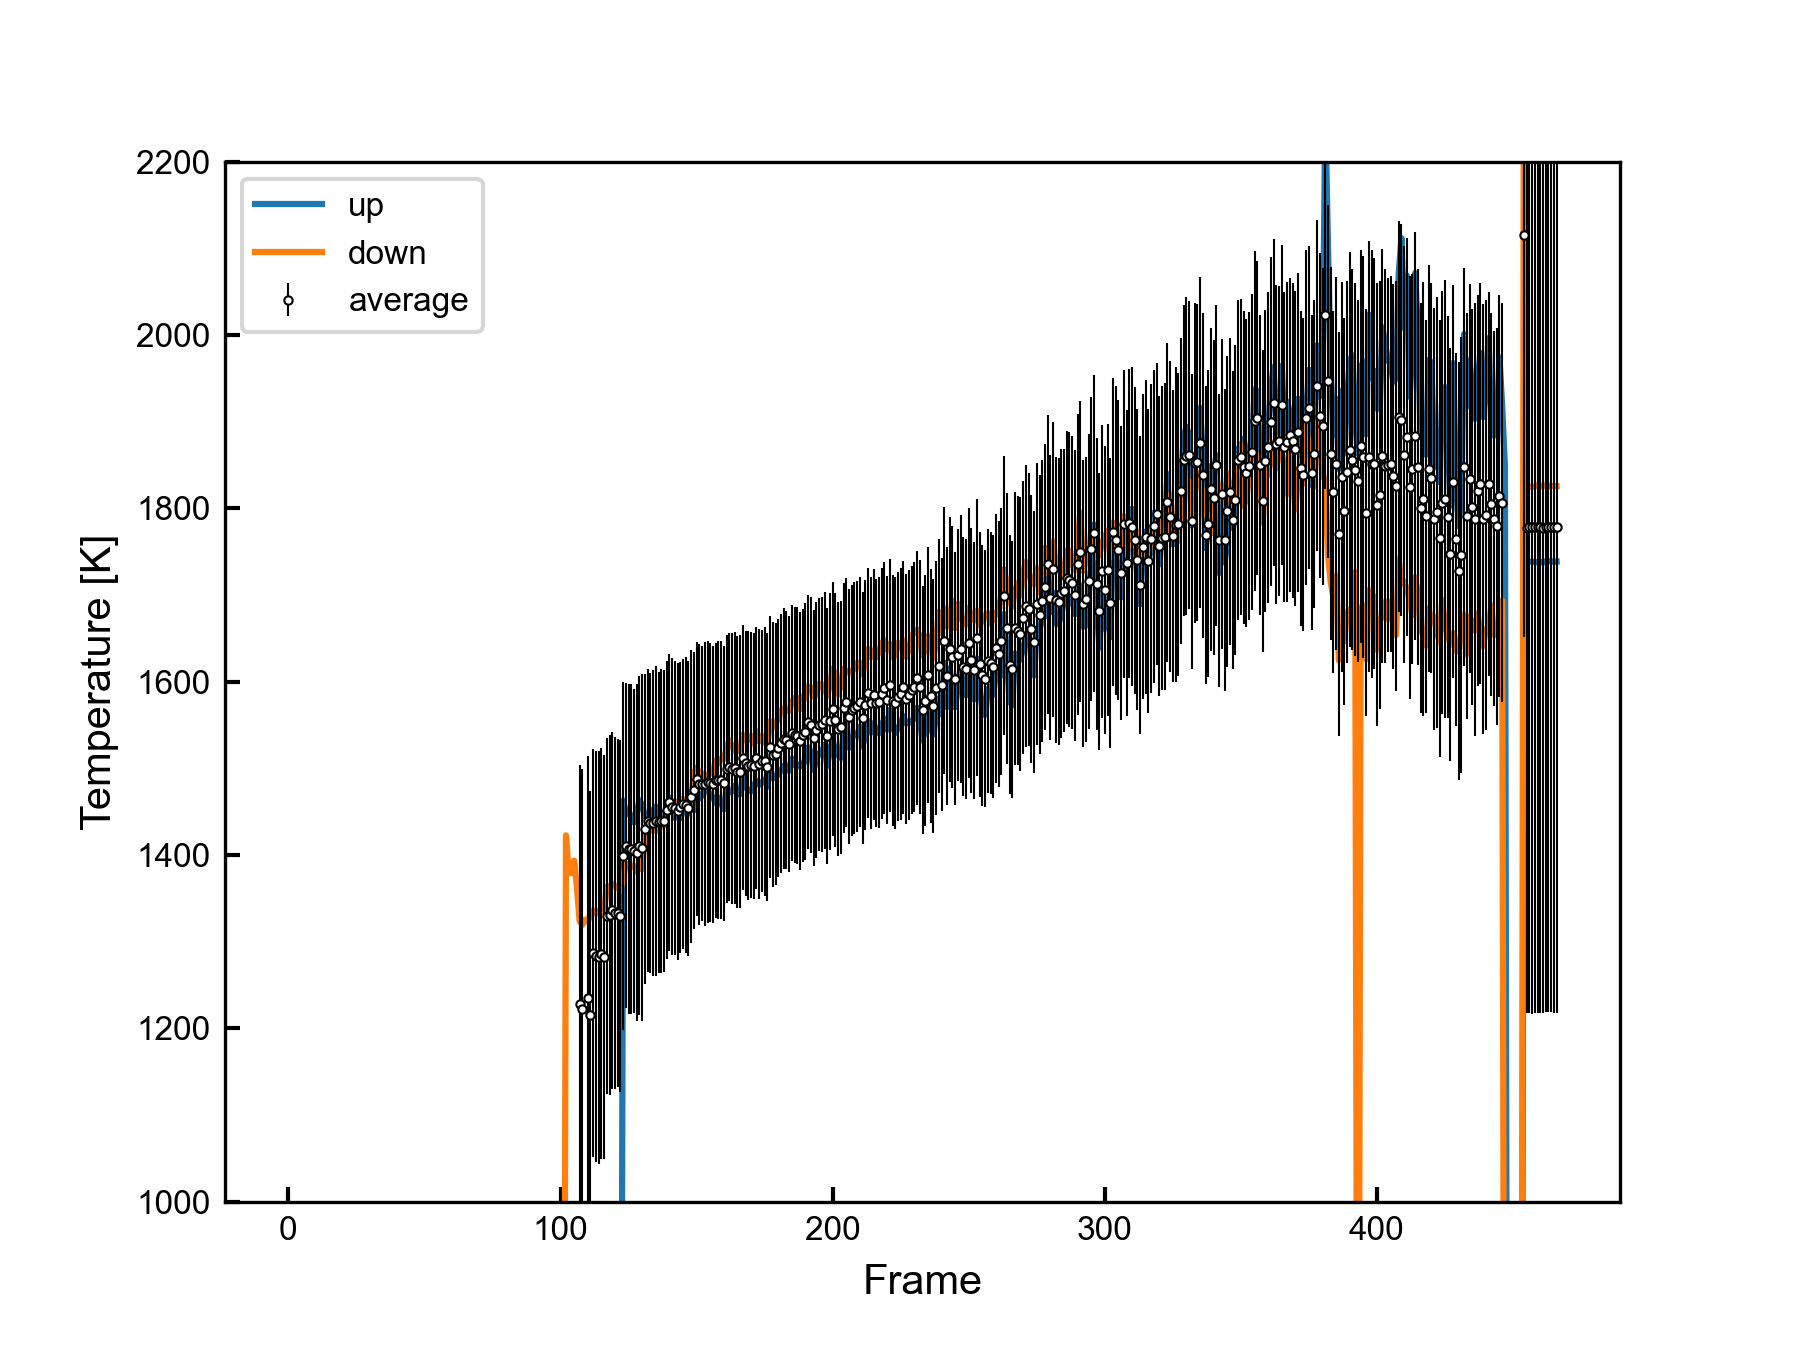

In [43]:
def calc_average():

    # ピクセルの範囲指定
    pixrange = dict()
    pixrange["up"] = (82,86) # 上流
    # pixrange["up"] = (83,85) # 上流
    # pixrange["up"] = (83,84) # 上流
    # pixrange["up"] = (84,85) # 上流
    pixrange["up"] = (83,87) # 上流
    # pixrange["up"] = (89,92) # 上流
    pixrange["down"] = (289,292) # 下流
    pixrange["down"] = (290,294) # 下流
    # pixrange["down"] = (288,298) # 下流

    index = -1
    # index = 0
    # index = 1

    ylim = (1500, 2200)
    ylim = (1000, 2200)

    if True:

        # データ格納用
        t = []
        e = []
        streams = ["up", "down"]

        # streamごとに計算
        for stream in streams:

            # ピクセル範囲の指定
            low = np.argmax(np.array(data["calc_ave"]["average"][stream]["pixes"]) == "pix = {}".format(pixrange[stream][0]))
            high = np.argmax(np.array(data["calc_ave"]["average"][stream]["pixes"]) == "pix = {}".format(pixrange[stream][1]))

            # 温度データの取得
            ts = np.array(data["calc_ave"]["average"][stream]["data"][low:high])
            es = np.array(data["calc_ave"]["average"][stream]["err"][low:high])

            # 計算
            weights = np.reciprocal(np.square(es))
            _t = np.average(ts, weights=weights, axis = 0)
            _e = np.average(es, weights=weights, axis = 0)
            _std = np.sum(np.square(_t - ts), axis = 0) / ts.shape[0]      

            # データ格納
            t.append(_t)
            e.append(np.sqrt(np.square(_e) + _std))

        # データをnp.ndarrayに変換
        t = np.vstack(t)
        e = np.vstack(e)

        # 計算
        weights = np.reciprocal(np.square(e))
        temp = np.average(
            t,
            axis = 0,
            weights = weights
        )
        err = np.average(
            e,
            axis = 0,
            weights = weights
        )
        std = np.sum(np.square(temp - t), axis = 0) / 2
        ert = np.sqrt(
            np.square(err) + np.square(std)
        )
        if index >= 0:
            temp = t[index]
            err = e[index]
        
        # データ保存
        csv = pd.DataFrame(
            np.vstack([
                temp,
                err,
            ]).T
        )
        csv.columns = ["Temperature [K]", "err [K]"]
        key = sys._getframe().f_code.co_name
        csvfilename = os.path.join(cachedir, key + ".csv")
        csv.to_csv(csvfilename)
        logger.debug(f"[{key}]: {csvfilename}")
        
        # fig作成
        fig, ax = plt.subplots()
        fig.set_size_inches((6,4.5))
        fig.set_dpi(300)

        # ax
        x = np.arange(temp.shape[0])
        for i, stream in enumerate(streams):
            ax.plot(
                x,
                t[i],
                label = stream
            )
        ax.errorbar(
            x = x,
            y = temp,
            yerr = err,
            lw = 0,
            fmt = "o",
            ms = 2,
            mfc = "1",
            elinewidth=0.5,
            c = "0",
            mew = 0.5,
            label = "average"
        )        
        ax.legend()
        ax.set_xlabel("Frame", fontsize = 10)
        ax.set_ylabel("Temperature [K]", fontsize = 10)
        ax.set_ylim(ylim)
        

        # 画像の保存
        fig.canvas.draw()
        img = im.frombuffer(
            mode = "RGBA",
            size = fig.canvas.get_width_height(),
            data = fig.canvas.buffer_rgba(), # type: ignore
            decoder_name = "raw"
        )
        key = sys._getframe().f_code.co_name
        imgfilename = cachedir + "/{}.png".format(key)
        img.save(imgfilename)
        logger.debug("[Save fig]: " + os.path.abspath(imgfilename))
        # pdffilename = cachedir + "/{}.pdf".format(key)
        # plt.savefig(pdffilename)
        # logger.debug("[Save fig]: " + os.path.abspath(pdffilename))
        plt.close()

        # 出力
        display(Image(filename = imgfilename, width = 600))

    return
calc_average()
del calc_average